In [1]:
import numpy as np
from collections import deque
import control
import torch
import pickle
torch.set_default_dtype(torch.float64)

import matplotlib.pyplot as plt
import matplotlib.colors as colors
saveFigs = True
FigDim1 = 3.0
FigDim2 = 1.5

from DeterministicPolicyGradient import DDPGagent
from utils import *
from ExtendedKF import *
from Example_system import *
from sqrtm import sqrtm
import time
import pylab as pl
from IPython import display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deviceCPU = "cpu"
print(device)

cuda


In [2]:
# Define model: dynamics, dynamics gradients, and noise covariances.
model = Model(stateDynamics, measurementDynamics, Q, R)
# Define information state: (mean, covariance), from an extended Kalman Fitler.
x0=torch.tensor([[0.1, 0.1, 0.1]])
P0=torch.diag(torch.tensor([0.5,0.5,0.5]))
Hyperstate = Extended_KF(x0, P0, model)
hidden_size = 64
actor_lr = 1e-3# * 10
critic_lr = actor_lr * 1
#noise = OUNoise(ru, uMax, uMin)
Horizon_Length = 32
RollOuts = 2
batch_size = 64#Horizon_Length# * RollOuts
gamma = 0.95
Max_reward = 500
EffectiveHorizonLength = (1 - gamma ** Horizon_Length) / (1 - gamma)
agent = DDPGagent(rx,ru, device, hidden_size, actor_lr, critic_lr, gamma, max_memory_size= batch_size * 32, tau=0.95)

In [3]:
def half_vectorize(A):
    n = A.shape[0]
    m = round((n ** 2 + n)/2)
    v = torch.zeros(m, 1)
    k = 0
    for i in range(n):
        for j in range(n):
            if (i <= j):
                v[k,0] = A[i,j]
                k += 1
    return v
            
        

In [4]:
def learn_control_law_DDPG(EpisodesNumber):
    agent = DDPGagent(rx,ru, device, hidden_size, actor_lr, critic_lr, gamma, max_memory_size= batch_size * 32, tau=0.95)
    rewards = []
    avg_rewards = []

    for episode in range(EpisodesNumber):
        episode_reward = 0
        ExplorationGamma = (EpisodesNumber - episode) / EpisodesNumber
        if (episode%100==0 & episode>1):
            agent.actor_learning_rate *= 1/1
            agent.critic_learning_rate *= 1/1
            ExplorationGamma *= 1/1
            print(episode)
            #agent.critic_learning_rate = agent.critic_learning_rate * 1/2
            #agent.actor_learning_rate = agent.actor_learning_rate * 1/2
        agent.actor.to(deviceCPU)
        for jj in range(RollOuts):
            Hyperstate.ChangeInitialStates(np.sqrt(2) * torch.randn(rx, 1), torch.diag(torch.rand(rx,)))
            true_state = sqrtm(Hyperstate.Covariance) @ torch.randn(rx, 1) + Hyperstate.Mean #we might need next t-step
            for step in range(Horizon_Length):
                state = torch.cat((Hyperstate.Mean, half_vectorize(Hyperstate.Covariance))).T
                action = agent.get_action(state)
                action = torch.atleast_2d(action + 1*ExplorationGamma * 0.5*torch.randn(1, 1)).detach()
                #true_state = sqrtm(Hyperstate.Covariance) @ torch.randn(rx, 1) + Hyperstate.Mean #we might need next t-step
                true_state_Plus = stateDynamics(true_state, action) + sqrtm(Q) @ torch.randn(rx, 1)
                true_state = true_state_Plus
                measurement_Plus_realization = measurementDynamics(true_state_Plus) + sqrtm(R) @ torch.randn(ry, 1)
                reward = - torch.mean(torch.sum((Hyperstate.Mean) ** 2) + torch.sum(Hyperstate.Covariance) + action ** 2) ###########################
                reward = torch.atleast_2d(reward)
                if reward < -Max_reward:
                    reward = torch.tensor([[-Max_reward]])
                Hyperstate.ApplyEKF(action, measurement_Plus_realization)
                new_state = torch.cat((Hyperstate.Mean, half_vectorize(Hyperstate.Covariance)))

                reward = reward.detach() / Max_reward 
                #reward = reward.detach().numpy() / Max_reward 
                agent.memory.push(state, action, new_state.T, reward)
                state = new_state
                episode_reward += reward * gamma ** step
        if len(agent.memory) >= batch_size:
            for jjj in  range(4):
                agent.update_critic(batch_size)
        for jjj in  range(1):
            agent.actor.to(device)
            agent.update_actor(batch_size*1)

        rewards.append(episode_reward.numpy() / (EffectiveHorizonLength * RollOuts) + 1)
        avg_rewards.append(np.mean(rewards[-5:]))
        """
        if episode%10==0:
            pl.plot(avg_rewards, 'r')
            pl.title(round(avg_rewards[-1], 3))
            display.clear_output(wait=True)
            display.display(pl.gcf())
            time.sleep(0.001)
        """
    agent.actor.to(deviceCPU)
    return avg_rewards, agent.actor.forward



In [5]:
num_of_learning_trials = 50
rec_rewards = []
rec_controllers = []
final_rewards = []
num_of_episodes = 250
achieved_num = 0
for i in range(num_of_learning_trials):
    print()
    reward_vec, controller = learn_control_law_DDPG(num_of_episodes)
    print("iteration #: ", i+1, " and final reward: ", reward_vec[-1])
    rec_rewards.append(reward_vec)
    final_rewards.append(reward_vec[-1])
    rec_controllers.append(controller)
    achieved_num += 1


iteration #:  1  and final reward:  0.9247065600136413

iteration #:  2  and final reward:  0.18256514072896884

iteration #:  3  and final reward:  0.1875272395683919



KeyboardInterrupt: 

In [6]:
DATA = [rec_rewards, final_rewards, rec_controllers]
with open('./data/saved_data', 'wb') as f:
    pickle.dump(DATA, f)

index_opt_controller = np.argmax(np.array(final_rewards))
K_RL = rec_controllers[index_opt_controller] #get_action

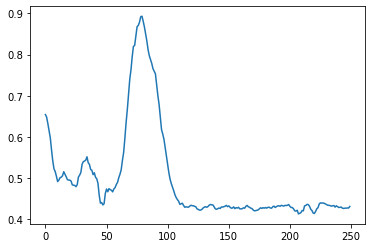

In [7]:
rewards = np.zeros((achieved_num, num_of_episodes))
for i in range(achieved_num):
    rewards[i,:] = np.array(rec_rewards[i])
plt.plot(np.mean(rewards, axis=0))

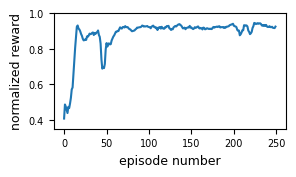

In [8]:
plt.style.use('default')
fig= plt.figure(figsize=(FigDim1,FigDim2))
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('episode number', fontsize=9)  
plt.ylabel('normalized reward', fontsize=9) 
plt.rc( 'text', usetex=True )
plt.plot(np.array(rec_rewards[index_opt_controller]))
plt.ylim([0.35, 1])
if saveFigs==True:
    plt.savefig('Figures/Example1_avgReward.pdf',bbox_inches ="tight")
plt.show()

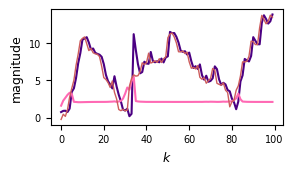

In [55]:
T = 100
x = np.ones(T)
trace = np.ones(T)
u = np.ones(T)
x_true=np.zeros((rx,T))

StateReq = deque([])
ActionReq = deque([])


Hyperstate.ChangeInitialStates(torch.rand(rx, 1), torch.diag(torch.rand(rx,)))
true_state = sqrtm(Hyperstate.Covariance) @ torch.randn(rx, 1) + Hyperstate.Mean #we might need next t-step

for k in range(T):
    state = torch.cat((Hyperstate.Mean, half_vectorize(Hyperstate.Covariance))).T
    action = K_RL(state)
    action = torch.atleast_2d(action.detach())
    true_state_Plus = stateDynamics(true_state, action) + sqrtm(Q) @ torch.randn(rx, 1)
    measurement_Plus_realization =  measurementDynamics(true_state_Plus) + sqrtm(R) @ torch.randn(ry, 1)
    true_state = sqrtm(Hyperstate.Covariance) @ torch.randn(rx, 1) + Hyperstate.Mean #we might need next t-step
    reward = - torch.mean((Hyperstate.Mean) ** 2 + Hyperstate.Covariance + action ** 2) ###########################
    StateReq.append(state)
    ActionReq.append(action)
    Hyperstate.ApplyEKF(action, measurement_Plus_realization)
    true_state = true_state_Plus
    x_true[:,k] = true_state.detach().numpy().squeeze()

for i in range(T):
    helper = StateReq[i].detach().numpy()
    x[i] = helper[0,0]
    trace[i] = helper[0,rx] + helper[0,rx+2] + helper[0,rx+5]
    helper = ActionReq[i].detach().numpy()
    u[i] = helper[0,0]

plt.style.use('default')
fig= plt.figure(figsize=(FigDim1,FigDim2))
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('$k$', fontsize=9)  
plt.ylabel('magnitude', fontsize=9) 
plt.rc( 'text', usetex=True )

k=56
plt.plot(range(T), x, color=list(colors.cnames)[k+4])
plt.plot(range(T), trace, color=list(colors.cnames)[k+2])
plt.plot(range(T), x_true[0,:], linewidth = 1, color=list(colors.cnames)[k+3])

if saveFigs==True:
   plt.savefig('Figures/Example1_ReinfLearn.pdf',bbox_inches ="tight")


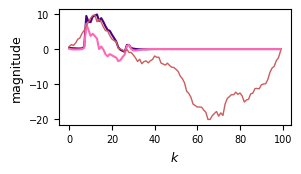

In [54]:

Klqr, _, _ = control.dlqr(A,B,np.eye(rx),np.eye(ru))
Klqr_tensor = torch.from_numpy(Klqr)
x = np.ones(T)
P = np.ones(T)
x_true=np.ones(T)

StateReq = deque([])
ActionReq = deque([])

Hyperstate.ChangeInitialStates(torch.rand(rx, 1), torch.diag(torch.rand(rx,)))
true_state = sqrtm(Hyperstate.Covariance) @ torch.randn(rx, 1) + Hyperstate.Mean #we might need next t-step


for k in range(T):
    state = torch.cat((Hyperstate.Mean, half_vectorize(Hyperstate.Covariance))).T
    action = -Klqr_tensor @ Hyperstate.Mean + 0 * torch.randn(1,1)
    action = action.clip(-5, 5)
    action = torch.atleast_2d(action.detach())
    true_state_Plus = stateDynamics(true_state, action) + sqrtm(Q) @ torch.randn(rx, 1)
    measurement_Plus_realization =  measurementDynamics(true_state_Plus) + sqrtm(R) @ torch.randn(ry, 1)
    StateReq.append(state)
    Hyperstate.ApplyEKF(action, measurement_Plus_realization)
    true_state = true_state_Plus
    x_true[k] = true_state[0,0].detach().numpy()

for i in range(T):
    helper = StateReq[i].detach().numpy()
    x[i] = helper[0,0]
    P[i] = helper[0,1]

plt.style.use('default')
fig= plt.figure(figsize=(FigDim1,FigDim2))
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('$k$', fontsize=9)  
#plt.ylabel('$k$', fontsize=9) 
plt.ylabel('magnitude', fontsize=9) 
plt.rc( 'text', usetex=True )
#plt.ylim([-500, 500])
k=56
plt.plot(range(T), x, color=list(colors.cnames)[k+4])
plt.plot(range(T), P, color=list(colors.cnames)[k+2])
plt.plot(range(T), x_true, linewidth = 1,color=list(colors.cnames)[k+3])
if saveFigs==True:
    plt.savefig('Figures/Example1_LQR.pdf',bbox_inches ="tight")


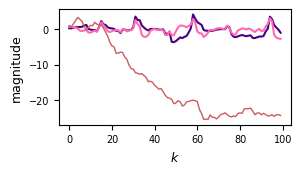

In [53]:

Klqr, _, _ = control.dlqr(A,B,np.eye(rx),np.eye(ru))
Klqr_tensor = torch.from_numpy(Klqr)
x = np.ones(T)
P = np.ones(T)
x_true=np.ones(T)

StateReq = deque([])
ActionReq = deque([])

Hyperstate.ChangeInitialStates(torch.rand(rx, 1), torch.diag(torch.rand(rx,)))
true_state = sqrtm(Hyperstate.Covariance) @ torch.randn(rx, 1) + Hyperstate.Mean #we might need next t-step


for k in range(T):
    state = torch.cat((Hyperstate.Mean, half_vectorize(Hyperstate.Covariance))).T
    action = -Klqr_tensor @ Hyperstate.Mean + 1 * torch.randn(1,1)
    action = action.clip(-5, 5)
    action = torch.atleast_2d(action.detach())
    true_state_Plus = stateDynamics(true_state, action) + sqrtm(Q) @ torch.randn(rx, 1)
    measurement_Plus_realization =  measurementDynamics(true_state_Plus) + sqrtm(R) @ torch.randn(ry, 1)
    StateReq.append(state)
    Hyperstate.ApplyEKF(action, measurement_Plus_realization)
    true_state = true_state_Plus
    x_true[k] = true_state[0,0].detach().numpy()

for i in range(T):
    helper = StateReq[i].detach().numpy()
    x[i] = helper[0,0]
    P[i] = helper[0,1]

plt.style.use('default')
fig= plt.figure(figsize=(FigDim1,FigDim2))
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('$k$', fontsize=9)  
#plt.ylabel('$k$', fontsize=9) 
plt.ylabel('magnitude', fontsize=9) 
plt.rc( 'text', usetex=True )
#plt.ylim([-500, 500])
k=56
plt.plot(range(T), x, color=list(colors.cnames)[k+4])
plt.plot(range(T), P, color=list(colors.cnames)[k+2])
plt.plot(range(T), x_true, linewidth = 1,color=list(colors.cnames)[k+3])
if saveFigs==True:
    plt.savefig('Figures/Example1_LQR_noise.pdf',bbox_inches ="tight")
